This tutorial demostrates Pointer Networks with readable code.

In [134]:
import math
import numpy as np
import time

import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader

import pandas as pd
import os
import networkx as nx

import matplotlib.pyplot as plt

USE_CUDA = False

In [135]:
NUMBER_NODES = 3
FEATURES_NUMBER = (NUMBER_NODES * NUMBER_NODES - NUMBER_NODES) // 2 

def load_data():
    train_df = pd.read_csv(os.path.join('..', '..', 'datasets', f'dataset_{NUMBER_NODES}_train.csv'))
    val_df = pd.read_csv(os.path.join('..', '..', 'datasets', f'dataset_{NUMBER_NODES}_val.csv'))
    test_df = pd.read_csv(os.path.join('..', '..', 'datasets', f'dataset_{NUMBER_NODES}_test.csv'))

    def get_tuple_tensor_dataset(row):
        X = row[0 : FEATURES_NUMBER].astype('int32')
        Y = row[FEATURES_NUMBER + 1 : ].astype('int32') # FEATURES_NUMBER + 1 Skips the optimal_band value

        X = torch.from_numpy(X)
        X = X.type(torch.long)

        Y = torch.from_numpy(Y)
        Y = Y.type(torch.long)
        return X, Y

    train_df = pd.concat((train_df, val_df))

    train_dataset = list(map(get_tuple_tensor_dataset, train_df.to_numpy()))
    test_dataset = list(map(get_tuple_tensor_dataset, test_df.to_numpy()))
    return train_dataset, test_dataset

train_data, test_data = load_data()

In [137]:
train_loader = DataLoader(train_data, batch_size=2, shuffle=True)
val_loader   = DataLoader(test_data, batch_size=2, shuffle=True)

In [138]:
# INIT VARIABLES

seq_len = FEATURES_NUMBER
embedding_size = 3
hidden_size = 3

batch_size = 2

embedding = nn.Embedding(seq_len, embedding_size)
encoder = nn.LSTM(embedding_size, hidden_size, batch_first=True)
decoder = nn.LSTM(embedding_size, hidden_size, batch_first=True)

n_glimpses = 1
# tanh_exploration = 10
tanh_exploration = FEATURES_NUMBER
# 10 or seq len? Is it 10 bsecause seq_len is 10 in the code example?

print('Outside loop of train_loader, decoder_start_input: ')
decoder_start_input = nn.Parameter(torch.FloatTensor(embedding_size))
print(decoder_start_input.shape)
print(decoder_start_input)
# I believe decoder_start_input got started with random parameters
decoder_start_input.data.uniform_(-(1. / math.sqrt(embedding_size)), 1. / math.sqrt(embedding_size))
# then decoder_start_input only gets regulated, by using uniform_, 
# passing -1 * 1. / math.sqrt(embedding_size) and 1. / math.sqrt(embedding_size) as arguments
print(decoder_start_input.shape)
print(decoder_start_input)

Outside loop of train_loader, decoder_start_input: 
torch.Size([3])
Parameter containing:
tensor([1.5988e+15, 4.5914e-41, 0.0000e+00], requires_grad=True)
torch.Size([3])
Parameter containing:
tensor([-0.5524, -0.1229, -0.1365], requires_grad=True)


In [139]:
# for sample_batch in train_loader:
it = iter(train_loader)
inputs, target = next(it)
print('train_loader loop started')

batch_size = inputs.size(0) 
print('batch_size - ', batch_size) # returns 1, the batch_size example
seq_len = inputs.size(1)
print('seq_len - ', seq_len) # returns 10, the input number of entries/shape example, and ensures it's ten

embedded = embedding(inputs) # embedding take seq_len (10) and embedding_size (2) as arguments
print('embedded data:')
print(embedded.shape)
print(embedded)

"""
in this cell example, the embedding_size is 2, thus shape will output [1, 10, 2]
embedding can be thought as a manner of representing data, for example:
for an array like [1, 2, 3], we could say that the numbers could be represented by a vector of dimension two,
and the '1' being the value "[0.5, 0.6]" for example, the others will be represented by a vector as well
turning into [[0.4, 0.5], [0,6, 0,7], [0,8, 0.9]], for example.
Embed means implant, i.e. implant [0.4, 0.5] in 1.

This can verifired passing a [1, 1, 1, 1, ..., 1] (ten ones), 
all of them in a run got the following embedded result (the batch_size was 1):
tensor([[[-0.5146, -0.6391],
        [-0.5146, -0.6391],
        [-0.5146, -0.6391],
        [-0.5146, -0.6391],
        [-0.5146, -0.6391],
        [-0.5146, -0.6391],
        [-0.5146, -0.6391],
        [-0.5146, -0.6391],
        [-0.5146, -0.6391],
        [-0.5146, -0.6391]]], grad_fn=<EmbeddingBackward0>)
thus, '1' is [-0.5146, -0.6391]
"""

target_embedded = embedding(target) # also embbed the target
print('target_embedded shape - ', target_embedded.shape) # clearly, also returns shape [1, 10, 2]

train_loader loop started
batch_size -  2
seq_len -  3
embedded data:
torch.Size([2, 3, 3])
tensor([[[ 0.5108,  0.3696,  1.4080],
         [ 0.8369, -1.8504, -0.5187],
         [ 0.5108,  0.3696,  1.4080]],

        [[ 0.5108,  0.3696,  1.4080],
         [ 0.5108,  0.3696,  1.4080],
         [ 0.5108,  0.3696,  1.4080]]], grad_fn=<EmbeddingBackward0>)
target_embedded shape -  torch.Size([2, 3, 3])


In [140]:
# encoder take embedding_size (2) and hidden_size (2) as arguments
encoder_outputs, (hidden, context) = encoder(embedded) 

print('-----LSTM (encoder) outputs-----')
print(encoder_outputs)
print('hidden state encoder output:')
print(hidden.shape)
print(hidden)
print('cell state output - ')
print(context.shape)
print(context)

mask = torch.zeros(batch_size, seq_len).byte()
# mask = torch.zeros(batch_size, 5).byte()
print('-----Mask-----')
print(mask.shape)
print(mask)

idxs = None
decoder_input = decoder_start_input.unsqueeze(0).repeat(batch_size, 1)
# this line only returns the decoder_start_input but with shape (batch_size, embedding_size), it repeats the values
# before this line, decoder_start_input was shape (embedding_size)
# torch.tensor([1,2,3]).unsqueeze(0) = tensor([[1, 2, 3]])
# torch.tensor([1,2,3]).unsqueeze(1) = tensor([[1], [2], [3]])
# torch.tensor([[1,2,3]]).unsqueeze(1)tensor([[[1, 2, 3]]])
print('-----decoder_input-----')
print(decoder_input.shape)
print(decoder_input)
# break

-----LSTM (encoder) outputs-----
tensor([[[-0.1803,  0.1272, -0.0994],
         [-0.1025,  0.0167, -0.1961],
         [-0.2570,  0.1382, -0.1751]],

        [[-0.1803,  0.1272, -0.0994],
         [-0.2784,  0.1529, -0.1644],
         [-0.3284,  0.1599, -0.2023]]], grad_fn=<TransposeBackward0>)
hidden state encoder output:
torch.Size([1, 2, 3])
tensor([[[-0.2570,  0.1382, -0.1751],
         [-0.3284,  0.1599, -0.2023]]], grad_fn=<StackBackward0>)
cell state output - 
torch.Size([1, 2, 3])
tensor([[[-0.4143,  0.4981, -0.7148],
         [-0.5385,  0.6709, -0.8713]]], grad_fn=<StackBackward0>)
-----Mask-----
torch.Size([2, 3])
tensor([[0, 0, 0],
        [0, 0, 0]], dtype=torch.uint8)
-----decoder_input-----
torch.Size([2, 3])
tensor([[-0.5524, -0.1229, -0.1365],
        [-0.5524, -0.1229, -0.1365]], grad_fn=<RepeatBackward0>)


In [141]:
class Attention(nn.Module):
    # def __init__(self, hidden_size, use_tanh=False, C=10, use_cuda=USE_CUDA):
    def __init__(self, hidden_size, use_tanh=False, C=NUMBER_NODES, use_cuda=USE_CUDA):
        super(Attention, self).__init__()
        
        self.use_tanh = use_tanh
        self.W_query = nn.Linear(hidden_size, hidden_size)
        self.W_ref   = nn.Conv1d(hidden_size, hidden_size, 1, 1)
        self.C = C
        
        V = torch.FloatTensor(hidden_size)
        if use_cuda:
            V = V.cuda()  
        self.V = nn.Parameter(V)
        self.V.data.uniform_(-(1. / math.sqrt(hidden_size)) , 1. / math.sqrt(hidden_size))
        
    def forward(self, query, ref):
        """
        Args: 
            query: [batch_size x hidden_size]
            ref:   ]batch_size x seq_len x hidden_size]
        """
        
        batch_size = ref.size(0)
        seq_len    = ref.size(1)

        ref = ref.permute(0, 2, 1)
        query = self.W_query(query).unsqueeze(2)  # [batch_size x hidden_size x 1]
        ref   = self.W_ref(ref)  # [batch_size x hidden_size x seq_len]

        expanded_query = query.repeat(1, 1, seq_len) # [batch_size x hidden_size x seq_len]
        V = self.V.unsqueeze(0).unsqueeze(0).repeat(batch_size, 1, 1) # [batch_size x 1 x hidden_size]

        logits = torch.bmm(V, F.tanh(expanded_query + ref)).squeeze(1)
        
        if self.use_tanh:
            logits = self.C * F.tanh(logits)
        else:
            logits = logits  
        return ref, logits

In [142]:
encoder_outputs.shape

torch.Size([2, 3, 3])

In [143]:
loss = 0
dataReturned = 0
seq_len_target = NUMBER_NODES

criterion = nn.CrossEntropyLoss()

glimpse = Attention(hidden_size, use_tanh=False, use_cuda=False)
pointer_layer = Attention(hidden_size, use_tanh=True, C=tanh_exploration, use_cuda=False)

def apply_mask_to_logits(logits, mask, idxs): 
  batch_size = logits.size(0)
  clone_mask = mask.clone()

  if idxs is not None:
    clone_mask[[i for i in range(batch_size)], idxs.data] = 1
    logits[clone_mask] = -np.inf
  return logits, clone_mask

for i in range(seq_len_target):
  # print(target[:,i])
  # decoder_input is shape [2, 3], but LSTM instance input must be [batch_size, sequence_length, input_size]
  decoder_input_unsqueeze_1 = decoder_input.unsqueeze(1)
  # decoder_input_unsqueeze_1 is shape [2, 1, 3]
  
  # the first hidden and context args will be the hidden and context encoder_outputs
  # after the first iteration, will be the last decoder hidden and context output:
  _, (hidden, context) = decoder(decoder_input_unsqueeze_1, (hidden, context))
  
  # hidden and context being inputs and outputs has shape: (num_layers, batch_size, hidden_size)
  query = hidden.squeeze(0)
  # query is shape (batch_size, hidden_size)

  for j in range(n_glimpses):
    ref, logits = glimpse(query, encoder_outputs)
    # glimpse return "something like a ref of encoder_outputs" to build the query
    # the query will be used in pointer_layer
    # ref shape - [2, 3, 10] (the shape of encoder_outputs got modified)
    # logits shape - [2, 10]

    logits, mask = apply_mask_to_logits(logits, mask, idxs)
    # in this case, mask will always be a zeros tensor with shape (batch_size - 2, sequence_length - 10)
    # and logits will be unmodified

    # Performs a batch matrix-matrix product of matrices
    print("FELIPE")
    print(logits.shape)
    print(F.softmax(logits).unsqueeze(2))
    print("FELIPE1")
    print(torch.sum(logits.softmax(1).unsqueeze(2)))
    print(torch.sum(logits.softmax(1).unsqueeze(2)[0]))
    print(logits.softmax(1).unsqueeze(2))
    print("FELIPE2")
    print(F.softmax(logits, dim=1).unsqueeze(2))
    query = torch.bmm(ref, F.softmax(logits).unsqueeze(2)).squeeze(2)

  _, logits = pointer_layer(query, encoder_outputs)
  print('-----pointer layer output-----')
  print(logits)
  
  logits, mask = apply_mask_to_logits(logits, mask, idxs)
  # in this case, mask will always be a zeros tensor with shape (batch_size - 2, sequence_length - 10)
  # and logits will be unmodified
  # print('-----mask-----')
  # print(mask)
  # print(logits)

  decoder_input = target_embedded[ : , i, : ]
  # decoder_input same data structure, but differente values

  loss += criterion(logits, target[:,i])
dataReturned = loss / seq_len

FELIPE
torch.Size([2, 3])
tensor([[[0.3398],
         [0.3210],
         [0.3392]],

        [[0.3312],
         [0.3340],
         [0.3348]]], grad_fn=<UnsqueezeBackward0>)
FELIPE1
tensor(2., grad_fn=<SumBackward0>)
tensor(1., grad_fn=<SumBackward0>)
tensor([[[0.3398],
         [0.3210],
         [0.3392]],

        [[0.3312],
         [0.3340],
         [0.3348]]], grad_fn=<UnsqueezeBackward0>)
FELIPE2
tensor([[[0.3398],
         [0.3210],
         [0.3392]],

        [[0.3312],
         [0.3340],
         [0.3348]]], grad_fn=<UnsqueezeBackward0>)
-----pointer layer output-----
tensor([[ 0.0014,  0.1681,  0.0389],
        [-0.0009,  0.0139,  0.0290]], grad_fn=<MulBackward0>)
FELIPE
torch.Size([2, 3])
tensor([[[0.3397],
         [0.3211],
         [0.3392]],

        [[0.3312],
         [0.3340],
         [0.3348]]], grad_fn=<UnsqueezeBackward0>)
FELIPE1
tensor(2., grad_fn=<SumBackward0>)
tensor(1., grad_fn=<SumBackward0>)
tensor([[[0.3397],
         [0.3211],
         [0.3392]],

   

C:\Users\Felipe\AppData\Local\Temp\ipykernel_13668\1086443292.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  print(F.softmax(logits).unsqueeze(2))
C:\Users\Felipe\AppData\Local\Temp\ipykernel_13668\1086443292.py:54: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  query = torch.bmm(ref, F.softmax(logits).unsqueeze(2)).squeeze(2)


In [144]:
class PointerNetLossOutside(nn.Module):
    def __init__(self, 
            embedding_size,
            hidden_size,
            seq_len,
            n_glimpses,
            tanh_exploration,
            use_tanh,
            seq_len_target,
            use_cuda=USE_CUDA):
        super(PointerNetLossOutside, self).__init__()
        
        self.embedding_size = embedding_size
        self.hidden_size    = hidden_size
        self.n_glimpses     = n_glimpses
        self.seq_len        = seq_len
        self.use_cuda       = use_cuda

        self.seq_len_target = seq_len_target
        
        self.embedding = nn.Embedding(seq_len, embedding_size)
        self.encoder = nn.LSTM(embedding_size, hidden_size, batch_first=True)
        self.decoder = nn.LSTM(embedding_size, hidden_size, batch_first=True)
        self.pointer = Attention(hidden_size, use_tanh=use_tanh, C=tanh_exploration, use_cuda=use_cuda)
        self.glimpse = Attention(hidden_size, use_tanh=False, use_cuda=use_cuda)
        
        self.decoder_start_input = nn.Parameter(torch.FloatTensor(embedding_size))
        self.decoder_start_input.data.uniform_(-(1. / math.sqrt(embedding_size)), 1. / math.sqrt(embedding_size))
        
        self.criterion = nn.CrossEntropyLoss()
        self.mse = nn.MSELoss()
        
    def apply_mask_to_logits(self, logits, mask, idxs): 
        batch_size = logits.size(0)
        clone_mask = mask.clone()

        if idxs is not None:
            clone_mask[[i for i in range(batch_size)], idxs.data] = 1
            logits[clone_mask] = -np.inf
        return logits, clone_mask
    
    def list_of_tuple_with_logits_true_to_verticalSequence(self, item_tuple):
        sequence = []
        softmax = nn.Softmax(dim=1)

        logits = softmax(item_tuple[0])
        true = item_tuple[1].numpy()

        argmax_indices = torch.argmax(logits, dim=1)
        for i in argmax_indices:
            sequence.append(i)

        sequence = np.array(sequence)
        return sequence, true

    def verticalSequence_to_horizontalSequence(self, verticalSequence):
        horizontalSquence = torch.tensor(verticalSequence, dtype=torch.float32)
        return horizontalSquence.permute(2, 1, 0)

    def verticalSequence_to_horizontalSequence_splitted(self, verticalSequence):
        horizontalSquence = torch.tensor(verticalSequence, dtype=torch.float32)
        permuted = horizontalSquence.permute(2, 1, 0)
        pred, true = torch.tensor_split(permuted, 2, dim=1)
        pred = torch.squeeze(pred)
        true = torch.squeeze(true)
        return pred, true

    def list_of_tuple_with_logits_true_to_sequences(self, pred):
        logits_sequences = {}
        true_sequences = {}

        batch_size = pred[0][0].shape[0]

        for i in range(batch_size):
            logits_sequences[str(i)] = []
            true_sequences[str(i)] = []

        for logits_batch, true_batch in pred:
            for batch_id, (logits, true) in enumerate(zip(logits_batch, true_batch)):
                logits_sequences[str(batch_id)].append(logits)
                true_sequences[str(batch_id)].append(true)

        pred_sequences = []
        target_sequences = []
        
        quantity_repeated = 0
        cases_with_repetition = 0
        for batch_id in logits_sequences:
            pred_sequence = []
            isCase_with_repetition = False

            logits_sequences[batch_id] = list(map(lambda x: x.softmax(0), logits_sequences[batch_id]))
            for logits in logits_sequences[batch_id]:
                appended = False
                while(not appended):
                    argmax_indice = torch.argmax(logits, dim=0)
                    if argmax_indice in pred_sequence:
                        logits[argmax_indice] = -1 # argmax already used = -1 (softmax is [0, 1])
                        quantity_repeated += 1
                        if not isCase_with_repetition:
                            cases_with_repetition += 1
                            isCase_with_repetition = True
                    else:
                        pred_sequence.append(argmax_indice.numpy())
                        appended = True
            pred_sequences.append(pred_sequence)

        for batch_id in true_sequences:
            target_sequences.append(true_sequences[batch_id])
        pred_sequences = torch.tensor(np.array(pred_sequences), dtype=torch.float)
        target_sequences = torch.tensor(np.array(target_sequences), dtype=torch.float)
        return pred_sequences, target_sequences, quantity_repeated, cases_with_repetition

    def loss_repeated_labels(self, sequenceOutput):
      batch_size = sequenceOutput.shape[0]

      used_labels, counts = torch.unique(sequenceOutput, return_counts=True)
      counts = counts.type(torch.FloatTensor)

      counts_shape = counts.shape[0]
      # output_shape = roundedOutput.shape[1]

      optimalCounts = torch.ones(counts_shape) * batch_size

      # return ((counts - optimalCounts)**2).mean() + (output_shape - counts_shape)
      # return torch.var(counts, unbiased=False)
      return self.mse(counts, optimalCounts)
    
    def mse_repeated_labels(self, roundedOutput):
      # computes the MSE of ([2., 1., 1.] - [1., 1., 1.])
      # in other words, the error from being an ones_like tensor
      used_labels, counts = torch.unique(roundedOutput, return_counts=True)
      counts = counts.type(torch.DoubleTensor)
      mse_loss = torch.nn.MSELoss()
      return mse_loss(counts, torch.ones_like(counts))

    def levenshtein_distance(self, roundedOutput):
      # computes how many modifications should be done in the tensor in 
      # order to not repeat any label, in any order (just not repeat)
      used_labels, counts = torch.unique(roundedOutput, return_counts=True)
      counts = counts.type(torch.DoubleTensor)
      return torch.sum(counts - 1)

    def forward(self, inputs, target):
        """
        Args: 
            inputs: [batch_size x sourceL]
        """
        batch_size = inputs.size(0)
        seq_len    = inputs.size(1)
        assert seq_len == self.seq_len
        
        embedded = self.embedding(inputs)
        target_embedded = self.embedding(target)
        encoder_outputs, (hidden, context) = self.encoder(embedded)
        
        mask = torch.zeros(batch_size, seq_len).byte()
        if self.use_cuda:
            mask = mask.cuda()
            
        idxs = None
       
        decoder_input = self.decoder_start_input.unsqueeze(0).repeat(batch_size, 1)
        
        loss = 0
        
        output = []
        # for i in range(seq_len):
        for i in range(self.seq_len_target):
            
            _, (hidden, context) = self.decoder(decoder_input.unsqueeze(1), (hidden, context))
            
            query = hidden.squeeze(0)
            for _ in range(self.n_glimpses):
                ref, logits = self.glimpse(query, encoder_outputs)
                logits, mask = self.apply_mask_to_logits(logits, mask, idxs)
                # even without the line above, the model make 5 zeros for the last 5 logits
                query = torch.bmm(ref, F.softmax(logits).unsqueeze(2)).squeeze(2) 
                
                
            _, logits = self.pointer(query, encoder_outputs)
            logits, mask = self.apply_mask_to_logits(logits, mask, idxs)
            # even without the line above, the model make 5 zeros for the last 5 logits
            
            decoder_input = target_embedded[:,i,:]

            output.append((logits, target[ : , i]))

            loss += self.criterion(logits, target[:,i])
            
        loss_output =  loss / self.seq_len_target

        verticalSequences = np.array(list(map(self.list_of_tuple_with_logits_true_to_verticalSequence, output)))
        pred_sequences, true_sequences = self.verticalSequence_to_horizontalSequence_splitted(verticalSequences)
        mse = self.mse(pred_sequences, true_sequences)
        loss_repeated = self.loss_repeated_labels(pred_sequences)
        custom_loss = mse + loss_repeated
        
        # pred, true, q, c = self.list_of_tuple_with_logits_true_to_sequences(output)
        # mse = self.mse(pred, true)
        # custom_loss = mse

        return output, loss_output + custom_loss

In [145]:
def train(train_loader, model, optimizer):
  loss = 0
  model.train()
  for batch, (x, y) in enumerate(train_loader):
    optimizer.zero_grad()

    logits_with_target_of_a_sequence, loss_output = model(x, y)
    loss_output.backward()

    loss += loss_output.item()

    optimizer.step()

    if batch % 100 == 0:
      print(f"Loss: {loss}, batch: {batch} ")
  return loss

def validate(val_loader, model):
  loss = 0
  model.eval()
  with torch.no_grad(): # turn off gradients computation
    for batch, (x, y) in enumerate(val_loader):
      logits_with_target_of_a_sequence, loss_output = model(x, y)

      loss += loss_output.item()
  return loss
  
def predict(val_loader, model):
  preds = []
  model.eval()
  with torch.no_grad():
    for x, y in val_loader:
      logits_with_target_of_a_sequence, loss_output = model(x, y)
      preds.append((x, logits_with_target_of_a_sequence))
  return preds
  # https://pytorch.org/docs/stable/generated/torch.nn.Softmax.html
  # https://www.tensorflow.org/tutorials/images/classification?authuser=1#download_and_explore_the_dataset 
  # the link above is without softmax in the model, but has softmax when prediciting
  # https://www.tensorflow.org/tutorials/keras/classification
  # the link above is with softmax in the model, thus has no softmax when prediciting

In [146]:
n_epochs = 52
train_loss = []
val_loss   = []

pointer_modified = PointerNetLossOutside(
    embedding_size=32,
    hidden_size=32,
    seq_len=FEATURES_NUMBER,
    n_glimpses=1,
    tanh_exploration=tanh_exploration,
    use_tanh=True,
    seq_len_target=NUMBER_NODES
)

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(pointer_modified.parameters(), lr=1e-4)

for epoch in range(n_epochs):
    print(f"epoch: {epoch + 1}")
    epoch_train_loss = train(train_loader, pointer_modified, optimizer)
    epoch_val_loss = validate(val_loader, pointer_modified)
    
    train_loss.append(epoch_train_loss)
    val_loss.append(epoch_val_loss)

epoch: 1
Loss: 3.265568256378174, batch: 0 
epoch: 2
Loss: 3.265524387359619, batch: 0 
epoch: 3
Loss: 3.2654848098754883, batch: 0 
epoch: 4
Loss: 3.2654495239257812, batch: 0 
epoch: 5
Loss: 3.2654190063476562, batch: 0 
epoch: 6
Loss: 3.2653920650482178, batch: 0 


C:\Users\Felipe\AppData\Local\Temp\ipykernel_13668\2554729034.py:178: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  query = torch.bmm(ref, F.softmax(logits).unsqueeze(2)).squeeze(2)


epoch: 7
Loss: 3.265369415283203, batch: 0 
epoch: 8
Loss: 3.265350341796875, batch: 0 
epoch: 9
Loss: 3.2653346061706543, batch: 0 
epoch: 10
Loss: 3.265322208404541, batch: 0 
epoch: 11
Loss: 3.2653121948242188, batch: 0 
epoch: 12
Loss: 3.2653050422668457, batch: 0 
epoch: 13
Loss: 3.2652995586395264, batch: 0 
epoch: 14
Loss: 3.2652955055236816, batch: 0 
epoch: 15
Loss: 3.7652931213378906, batch: 0 
epoch: 16
Loss: 3.765291690826416, batch: 0 
epoch: 17
Loss: 3.7652907371520996, batch: 0 
epoch: 18
Loss: 3.7652904987335205, batch: 0 
epoch: 19
Loss: 3.7652904987335205, batch: 0 
epoch: 20
Loss: 3.7652907371520996, batch: 0 
epoch: 21
Loss: 3.765291213989258, batch: 0 
epoch: 22
Loss: 3.765291213989258, batch: 0 
epoch: 23
Loss: 3.765291690826416, batch: 0 
epoch: 24
Loss: 3.765291690826416, batch: 0 
epoch: 25
Loss: 3.765291690826416, batch: 0 
epoch: 26
Loss: 3.765291213989258, batch: 0 
epoch: 27
Loss: 18.765291213989258, batch: 0 
epoch: 28
Loss: 18.765289306640625, batch: 0 
e

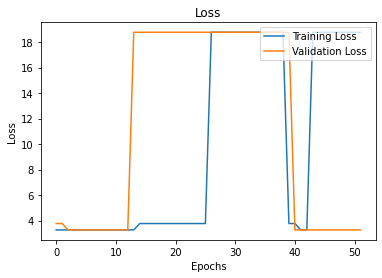

<Figure size 432x288 with 0 Axes>

In [147]:
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(loc='upper right')
plt.title('Loss')
plt.show()
plt.clf()

In [148]:
preds = predict(val_loader, pointer_modified)

softmax = nn.Softmax(dim=1)

it = iter(preds)
input_data, pred = next(it)

C:\Users\Felipe\AppData\Local\Temp\ipykernel_13668\2554729034.py:178: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  query = torch.bmm(ref, F.softmax(logits).unsqueeze(2)).squeeze(2)


In [149]:
input_data

tensor([[0, 1, 1],
        [1, 1, 1]])

In [150]:
pred

[(tensor([[0.2638, 0.2667, 0.2500],
          [0.2751, 0.2533, 0.2347]]),
  tensor([0, 0])),
 (tensor([[0.2638, 0.2667, 0.2500],
          [0.2751, 0.2533, 0.2347]]),
  tensor([2, 2])),
 (tensor([[0.2638, 0.2667, 0.2500],
          [0.2751, 0.2533, 0.2347]]),
  tensor([1, 1]))]

In [151]:
pred[0][0].shape[0]

2

In [152]:
for i in preds:
  # total_length += i[0][0].shape[0]
  # print(pred[0][0].shape[0])
  print(i[0].shape[0])

2


In [153]:
# this function is in PointerNetLossOutside, repeated on purpose for visualize the returned data
def list_of_tuple_with_logits_true_to_verticalSequence(item_tuple):
  sequence = []

  logits = softmax(item_tuple[0])
  true = item_tuple[1].numpy()

  argmax_indices = torch.argmax(logits, dim=1)

  for i in argmax_indices:
    sequence.append(i)

  sequence = np.array(sequence)
  return sequence, true
  
verticalSequences = np.array(list(map(list_of_tuple_with_logits_true_to_verticalSequence, pred)))
verticalSequences

array([[[1, 0],
        [0, 0]],

       [[1, 0],
        [2, 2]],

       [[1, 0],
        [1, 1]]], dtype=int64)

In [154]:
# this function is also in PointerNetLossOutside, repeated on purpose for visualize the returned data
def verticalSequence_to_horizontalSequence(verticalSequence):
  horizontalSquence = torch.tensor(verticalSequence)
  return horizontalSquence.permute(2, 1, 0)

def verticalSequence_to_horizontalSequence_splitted(verticalSequence):
      horizontalSquence = torch.tensor(verticalSequence)
      permuted = horizontalSquence.permute(2, 1, 0)
      pred, true = torch.tensor_split(permuted, 2, dim=1)
      pred = torch.squeeze(pred)
      true = torch.squeeze(true)
      return pred, true

# [4, 3, 6, 5, 5, 5, 2]
def list_of_tuple_with_logits_true_to_sequences(pred):
  logits_sequences = {}
  true_sequences = {}

  for i in range(batch_size):
    logits_sequences[str(i)] = []
    true_sequences[str(i)] = []

  for logits_batch, true_batch in pred:
    for batch_id, (logits, true) in enumerate(zip(logits_batch, true_batch)):
      logits_sequences[str(batch_id)].append(logits)
      true_sequences[str(batch_id)].append(true)

  pred_sequences = []
  target_sequences = []
  
  quantity_repeated = 0
  cases_with_repetition = 0
  for batch_id in logits_sequences:
    pred_sequence = []
    isCase_with_repetition = False

    logits_sequences[batch_id] = list(map(lambda x: x.softmax(0), logits_sequences[batch_id]))
    for logits in logits_sequences[batch_id]:
      appended = False
      while(not appended):
        argmax_indice = torch.argmax(logits, dim=0)
        if argmax_indice in pred_sequence:
          logits[argmax_indice] = -1 # argmax already used = -1 (softmax is [0, 1])
          quantity_repeated += 1
          if not isCase_with_repetition:
            cases_with_repetition += 1
            isCase_with_repetition = True
        else:
          pred_sequence.append(argmax_indice)
          appended = True
    pred_sequences.append(pred_sequence)

  for batch_id in true_sequences:
    target_sequences.append(true_sequences[batch_id])
  return pred_sequences, target_sequences, quantity_repeated, cases_with_repetition

horizontalSequences = verticalSequence_to_horizontalSequence(verticalSequences)
# print(horizontalSequences)
sequence_pred, sequence_true = verticalSequence_to_horizontalSequence_splitted(verticalSequences)
sequence_true

tensor([[0, 2, 1],
        [0, 2, 1]])

In [155]:
pred_sequences, target_sequences, quantity_repeated, cases_with_repetition = list_of_tuple_with_logits_true_to_sequences(pred)
print(np.array(input_data))
print(np.array(pred_sequences))
print(np.array(target_sequences))
print(quantity_repeated)
print(cases_with_repetition)
# 
# horizontalSequences = verticalSequence_to_horizontalSequence(verticalSequences)
# horizontalSequences

[[0 1 1]
 [1 1 1]]
[[1 0 2]
 [0 1 2]]
[[0 2 1]
 [0 2 1]]
6
2


In [156]:
import numpy as np

NUMBER_NODES = 3
FEATURES_NUMBER = (NUMBER_NODES * NUMBER_NODES - NUMBER_NODES) // 2 

def getGraph(upperTriangleAdjMatrix):
    dense_adj = np.zeros((NUMBER_NODES, NUMBER_NODES))
    k = 0
    for i in range(NUMBER_NODES):
        for j in range(NUMBER_NODES):
            if i == j:
                continue
            elif i < j:
                dense_adj[i][j] = upperTriangleAdjMatrix[k]
                k += 1
            else:
                dense_adj[i][j] = dense_adj[j][i]
    return dense_adj

def get_bandwidth(Graph, nodelist):
    Graph = nx.Graph(Graph)
    if not Graph.edges:
        return 0
    if nodelist.all() != None:
        L = nx.laplacian_matrix(Graph, nodelist=nodelist)
    else:
        L = nx.laplacian_matrix(Graph)
    x, y = np.nonzero(L)
    return (x-y).max()

def get_valid_sequence(output):
  maximum = FEATURES_NUMBER - 1
  maximum_valid = NUMBER_NODES - 1

  valid_output = np.ones(NUMBER_NODES)
  for _ in range(NUMBER_NODES):
    while(maximum not in output):
      maximum -= 1
    index = output.index(maximum)
    output[index] = FEATURES_NUMBER
    valid_output[index] = maximum_valid
    maximum_valid -= 1
  
  return valid_output

"""
    the list_of_tuple_with_logits_true_to_sequences algorithm ensures that the sequence will be different numbers
    but does not ensures that could not get a output like that:
    [0, 2, 1, 3, 5, 4, 7] # the correct range is [0, 6]
    fix that
"""
# print(get_valid_sequence([0, 2, 1, 3, 7]))
# print(get_valid_sequence([0, 1, 2, 3, 10]))
# print(get_valid_sequence([0, 2, 1, 8, 7]))
# print(get_valid_sequence([0, 1, 2, 7, 10]))

def get_valid_pred(pred):
    valid = np.ones(NUMBER_NODES)
    labels = np.arange(0, NUMBER_NODES)
    for i in labels:
        min_value = np.amin(pred)
        min_idx, = np.where(pred == min_value)
        min_idx = min_idx[0]
        pred[min_idx] = 100
        valid[min_idx] = i
    return valid

# both functions can be used
print("get_valid_pred")
print(get_valid_pred([0, 2, 1, 3, 7]))
print(get_valid_pred([0, 1, 2, 3, 10]))
print(get_valid_pred([0, 2, 1, 8, 7]))
print(get_valid_pred([0, 1, 2, 7, 10]))

get_valid_pred
[0. 2. 1.]
[0. 1. 2.]
[0. 2. 1.]
[0. 1. 2.]


In [157]:
preds = predict(val_loader, pointer_modified)

sumTest_original = []
sumTest_pred = []
sumTest_true = []

count_total = 0
cases_with_repetition_total = 0

start = time.time()
for input_data, pred in preds:
  pred_sequences, target_sequences, quantity_repeated, cases_with_repetition = list_of_tuple_with_logits_true_to_sequences(pred)
  for x, output, true in zip(input_data, pred_sequences, target_sequences):
    """
    print(x)
    print(output)
    print(true)
    """

    count_total += quantity_repeated
    cases_with_repetition_total += cases_with_repetition

    output = get_valid_sequence(output)

    graph = getGraph(x)
    original_band = get_bandwidth(graph, np.array(None))
    sumTest_original.append(original_band)

    pred_band = get_bandwidth(graph, np.array(output))
    sumTest_pred.append(pred_band)

    true_band = get_bandwidth(graph, np.array(true))
    sumTest_true.append(true_band)

    # print("Bandwidth")
    # print(original_band)
    # print(pred_band)
    # print(true_band)
end = time.time()

C:\Users\Felipe\AppData\Local\Temp\ipykernel_13668\2554729034.py:178: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  query = torch.bmm(ref, F.softmax(logits).unsqueeze(2)).squeeze(2)


In [158]:
total_length = 0
for i in preds:
  total_length += i[0].shape[0]

In [159]:
print('Quantidade de rótulos repetidos, exemplo [1, 1, 1, 1, 1, 1, 1] conta como 6 - ', count_total)
print('Quantidade de saídas com repetição, exemplo [1, 1, 1, 1, 1, 1, 1] conta como 1 - ', cases_with_repetition)
test_length = total_length

print('Test length - ', test_length)
print('Tempo medio - ', (end - start) / test_length)
print("Bandwidth mean±std")
print(f'{np.mean(sumTest_original)}±{np.std(sumTest_original)}')
print("Pred bandwidth mean±std")
print(f'{np.mean(sumTest_pred)}±{np.std(sumTest_pred)}')
print("True bandwidth mean±std")
print(f'{np.mean(sumTest_true)}±{np.std(sumTest_true)}')

Quantidade de rótulos repetidos, exemplo [1, 1, 1, 1, 1, 1, 1] conta como 6 -  12
Quantidade de saídas com repetição, exemplo [1, 1, 1, 1, 1, 1, 1] conta como 1 -  2
Test length -  2
Tempo medio -  0.011000514030456543
Bandwidth mean±std
2.0±0.0
Pred bandwidth mean±std
2.0±0.0
True bandwidth mean±std
1.5±0.5
